# Dense Neural Network with overfitting prevention

### Importing and Data Preprocessing

In [1]:
import re
import collections
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [3]:
import pandas as pd
import numpy as np

df =  pd.read_csv('cleaned.csv', encoding='UTF-8')

#df = df.rename(columns={'Tweet': 'text'})
df.head()

,Unnamed: 0.1,Unnamed: 0,rating,id,date,flag,user,text,tidy_tweet
0,0,894059,1,1692137234,Sun May 03 19:21:16 PDT 2009,NO_QUERY,cariquinn,@NZSoulGirl Hey there! Yum...sangria! And snor...,hey snorkel sound amaze glad fun
1,1,1467016,1,2064555259,Sun Jun 07 06:35:08 PDT 2009,NO_QUERY,Nigel_Derbyfan,Enjoyed that. Now for Sunday dinner,enjoy sunday dinner
2,2,1150195,1,1978427680,Sat May 30 23:19:31 PDT 2009,NO_QUERY,YoungmoneyReef,"show was awesome vegas, u made the last night ...",show awesome vega make last night tour memorable
3,3,1274449,1,2000971003,Mon Jun 01 23:28:13 PDT 2009,NO_QUERY,DoreenCotinola,@DKA34 Damon welcome to twitter Nation!,damon welcome twitter nation
4,4,620938,0,2228589656,Thu Jun 18 14:37:57 PDT 2009,NO_QUERY,tmac_82,@teemwilliams &amp; @dc3plusme: I thought I fo...,think find mine leave guy think well


Data Spliting to Train and Test

In [4]:
from tensorflow.keras.layers import InputLayer, Dense, SimpleRNN, Activation, Dropout, Conv1D
from tensorflow.keras.layers import Embedding, Flatten, LSTM, GRU
from keras import models
from keras import layers
from keras import regularizers

NB_WORDS = 10000
VAL_SIZE = 1000
NB_START_EPOCHS = 20
BATCH_SIZE = 512

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['rating'], test_size=0.1, random_state=37)


# Assert that the number of samples in X_train is equal to the number of samples in y_train
assert X_train.shape[0] == y_train.shape[0]

# Assert that the number of samples in X_test is equal to the number of samples in y_test
assert X_test.shape[0] == y_test.shape[0]

# Print the number of data samples in the training and testing sets
print(f'Train data samples: {X_train.shape[0]}')
print(f'Test data samples: {X_test.shape[0]}')


Train data samples: 9000
Test data samples: 1000


Converting words to numbers

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
import collections
# Convert X_train to a list of strings
X_train = [str(x) for x in X_train]

# Initialize tokenizer with specified parameters
tok = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")

# Fit tokenizer on training data
tok.fit_on_texts(X_train)

# Print information about the tokenizer
print("Fitted tokenizer on {} documents".format(tok.document_count))
print("{} words in dictionary".format(tok.num_words))
print("The Top 10 most common words are:", collections.Counter(tok.word_counts).most_common(10))


Fitted tokenizer on 9000 documents
10000 words in dictionary
The Top 10 most common words are: [('i', 4305), ('to', 3226), ('the', 3044), ('a', 2172), ('my', 1823), ('and', 1698), ('you', 1495), ('it', 1399), ('is', 1358), ('in', 1255)]


### visualising

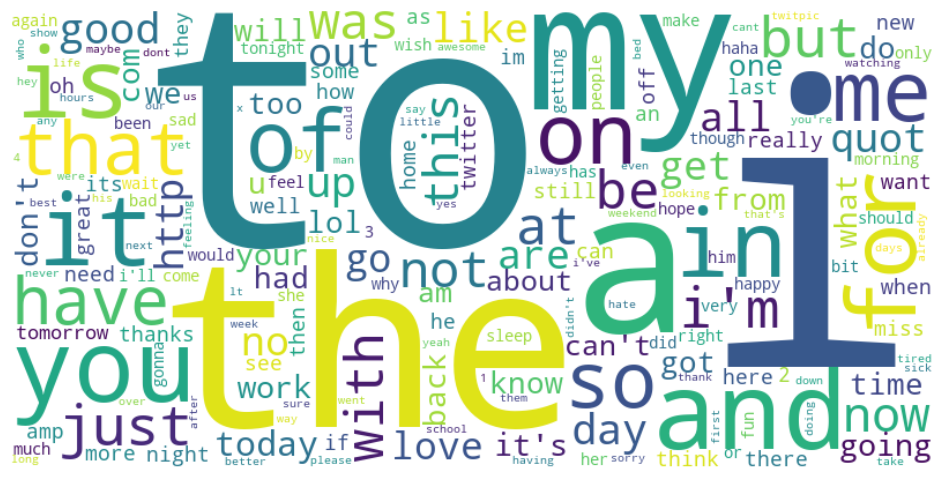

In [6]:
from wordcloud import WordCloud

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tok.word_counts)

# Display the word cloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

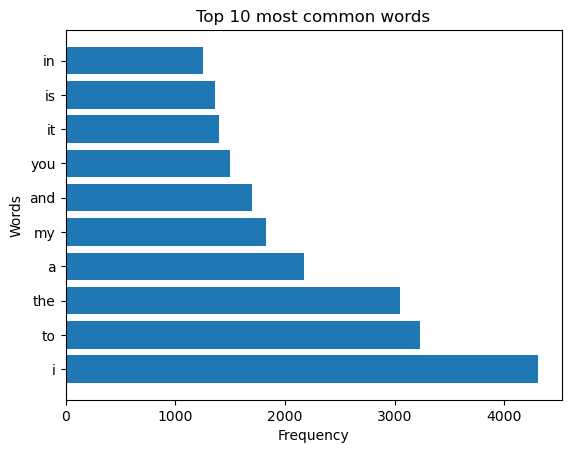

In [7]:
import matplotlib.pyplot as plt
import collections

# Get the top 5 most common words and their frequency counts
top_words = collections.Counter(tok.word_counts).most_common(10)
words, counts = zip(*top_words)

# Create a horizontal bar chart
plt.barh(words, counts)
plt.title('Top 10 most common words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()


In [8]:
# Convert to strings
X_train = [str(x) for x in X_train]
# Convert to sequences 
X_train_seq = tok.texts_to_sequences(X_train)
# Convert to strings
X_test = [str(x) for x in X_test]
# Convert to sequences 
X_test_seq = tok.texts_to_sequences(X_test)

# Print the first example before and after conversion
print('Example: "{}"'.format(X_train[0]))
print('Before conversion: {}\nAfter conversion: {}'.format(X_train[0], X_train_seq[0]))

Example: "@TweetFakes idk what my life would be without you. great work "
Before conversion: @TweetFakes idk what my life would be without you. great work 
After conversion: [5366, 827, 57, 5, 173, 119, 22, 296, 7, 95, 43]


### One Hot

In [50]:
import numpy as np

#    One-hot encodes a list of sequences.
def one_hot_encode_sequences(sequences, num_words):
    """
    VARs:
        sequences: A list of sequences to be encoded.
        num_words: The number of words in the vocabulary.

    Returns:
        A numpy array of shape (len(sequences), num_words), where each row represents a one-hot encoded sequence.
    """
    one_hot_sequences = np.zeros((len(sequences), num_words))
    for i, seq in enumerate(sequences):
        one_hot_sequences[i, seq] = 1
    return one_hot_sequences

# Example usage
X_train_oh = one_hot_encode_sequences(X_train_seq, NB_WORDS)
X_test_oh = one_hot_encode_sequences(X_test_seq, NB_WORDS)

print(f'ONE HOT: "{X_train_seq[0]}" is converted to {X_train_oh[0]}')
print(f'features with a value of 1 :{X_train_oh[0].sum()}')


ONE HOT: "[5366, 827, 57, 5, 173, 119, 22, 296, 7, 95, 43]" is converted to [0. 0. 0. ... 0. 0. 0.]
features with a value of 1 :11.0


### Label Encoding

In [54]:
# Instantiate a LabelEncoder object
le = LabelEncoder()

# Fit the LabelEncoder object
y_train_le = le.fit_transform(y_train)

# Transform the test set labels 
y_test_le = le.transform(y_test)

# Convert into one-hot encoded vectors
y_train_oh = to_categorical(y_train_le)

# Convert into one-hot encoded vectors
y_test_oh = to_categorical(y_test_le)

# Print the label encoding results
print(f'Label "{y_train[0]}" is converted to {y_train_le[0]}')

# Print the one-hot encoding results 
print(f'LE Label "{y_train_le[0]}" is converted to {y_train_oh[0]}')


Label "1" is converted to 1
LE Label "1" is converted to [0. 1.]


### train and test seperation

In [55]:
import numpy as np
from sklearn.model_selection import train_test_split

# Splitting the data
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

# Asserting the shapes of the validation and training sets
assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

# Printing the shape of the validation set
print('validation set Shape:', X_valid.shape)


validation set Shape: (900, 10000)


### functions for plotting

In [12]:
import matplotlib.pyplot as plt

def compare_loss_with_baseline(history, model_name):
    """
    Compare the validation loss of a trained model with the baseline model's validation loss.
    
    Args:
    - history: The training history of the model to be compared.
    - model_name: The name of the model to be compared.
    """
    baseline_val_loss = base_history.history['val_loss']
    model_loss = history.history['val_loss']
    epochs = range(1, len(baseline_val_loss) + 1)

    plt.plot(epochs, baseline_val_loss, 'b', label='Validation Loss Baseline Model')
    plt.plot(epochs, model_loss, 'ro', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()
    
#    #Plots a given evaluation metric for the training and validation sets
    #over the course of the training epochs.
    
def plot_metric(history, metric_name):
    """
    Arguments:
    history -- A Keras history object containing training and validation metrics
    metric_name -- A string specifying the metric to plot

    Returns:
    None
    """

    metric = history.history[metric_name]
    val_metric = history.history[f"val_{metric_name}"]

    epochs = range(1, len(metric) + 1)

    plt.plot(epochs, metric, 'b', label=f"Train {metric_name}")
    plt.plot(epochs, val_metric, 'ro', label=f"Validation {metric_name}")
    plt.legend()
    plt.show()
    
#    Plots the training and validation accuracy and loss of a neural network model over epochs.

def plot_hist(history, title):
    """
    Vars:
    - history: A Keras History object representing the training history of a model.
    """
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
    
    ax1.plot(history.history['accuracy'], c= 'b')
    ax1.plot(history.history['val_accuracy'], c='r')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'], loc='upper left')

    ax2.plot(history.history['loss'], c='m')
    ax2.plot(history.history['val_loss'], c='c')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'], loc='upper left')
     # Add a title to the entire image
    fig.suptitle(title, fontsize=14)
    plt.show()

# BASELINE

In [56]:
from tensorflow.keras.preprocessing.text import Tokenizer
# Convert the values in the 'text' column to strings
texts = [str(text) for text in df['text']]
# Assuming that the list `texts` contains your text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1

In [57]:
import tensorflow as tf
from tensorflow.keras import layers, models
max_length = 10000
'''def build_base_model(input_shape):
    """
    Returns a base model architecture with 2 dense layers and a softmax output layer
    """
    model = models.Sequential()
    model.add(layers.Dense(units=64, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dense(units=2, activation='softmax'))
    return model
'''

def build_base_model(input_shape):
    """
    Returns a model architecture with 3 dense layers and a softmax output layer
    """
    base_model = models.Sequential()
    #model.add(layers.Dense(units=128, activation='relu', input_shape=input_shape))
    base_model.add(layers.Dense(units=64, activation='relu', input_shape=input_shape))
    base_model.add(layers.Dense(units=32, activation='relu'))
    base_model.add(layers.Dense(units=16, activation='relu'))
    base_model.add(layers.Dense(units=2, activation='softmax'))
    return base_model

if __name__ == "__main__":
    # Define the input shape
    NB_WORDS = 10000
    input_shape = (NB_WORDS, )

    # Build and print the base model architecture
    base_model = build_base_model(input_shape)
    base_model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 64)                640064    
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 dense_33 (Dense)            (None, 16)                528       
                                                                 
 dense_34 (Dense)            (None, 2)                 34        
                                                                 
Total params: 642,706
Trainable params: 642,706
Non-trainable params: 0
_________________________________________________________________


In [58]:
def train_deep_model(model):
    '''model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])'''
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    train_history = model.fit(X_train_rest,
                       y_train_rest,
                       epochs=NB_START_EPOCHS,
                       batch_size=BATCH_SIZE,
                       validation_data=(X_valid, y_valid),
                       verbose=0)
    #pred = model.predict(X_valid)
    return train_history#, pred

In [59]:
#Train
base_history = train_deep_model(base_model)

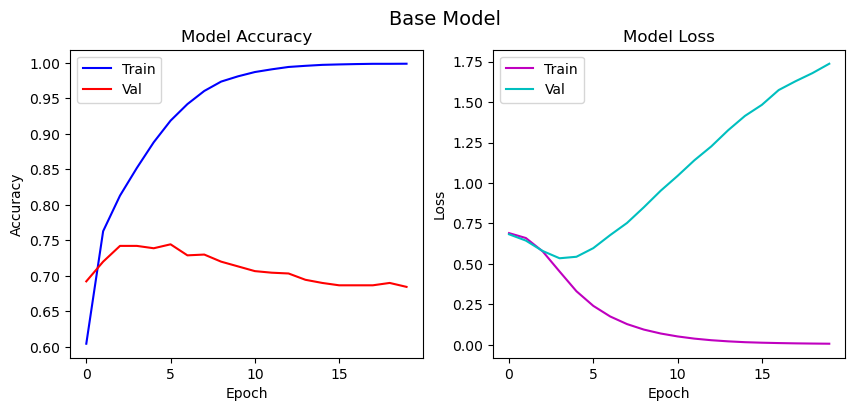

In [60]:
plot_hist(base_history,'Base Model')

In [61]:
from sklearn.metrics import classification_report

def print_classification_report(model, X_valid, y_valid):
    # Make predictions using the model
    y_pred = model.predict(X_valid).argmax(axis=1)
    
    # Generate the classification report and print it
    report = classification_report(y_valid.argmax(axis=1), y_pred)
    print(report)
    
print_classification_report(base_model, X_valid, y_valid)

29/29 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       434
           1       0.71      0.67      0.69       466

    accuracy                           0.68       900
   macro avg       0.68      0.69      0.68       900
weighted avg       0.69      0.68      0.68       900



# Overfitting prevention

## 1. Dropout

In [20]:
#    Creates a deep learning model with dropout layers.
def create_dropout_model(num_words, dropout_rate=0.25):
    """
    Vars:
    - num_words: The number of words in the input layer.
    - dropout_rate: The dropout rate used in the dropout layers. Default is 0.35.

    Returns:
    - A deep learning model with 3 dense layers and two dropout layers.
    """
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(num_words,)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(2, activation='softmax'))
    
    return model

#NB_WORDS = 1000 # example value
dropout_model = create_dropout_model(NB_WORDS)
dropout_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 2)                 130       
                                                                 
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


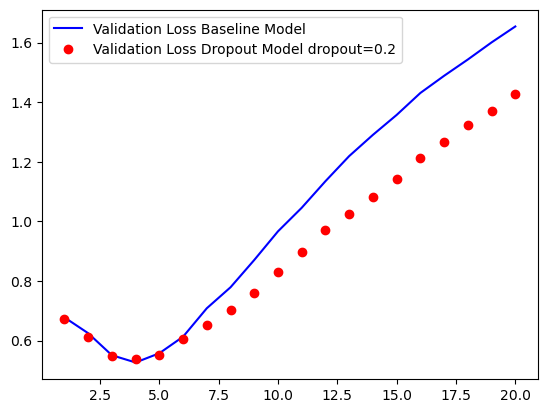

In [21]:
dropout_model = create_dropout_model(NB_WORDS, dropout_rate=0.2)
dropout_history = train_deep_model(dropout_model) 
compare_loss_with_baseline(dropout_history, 'Dropout Model dropout=0.2')

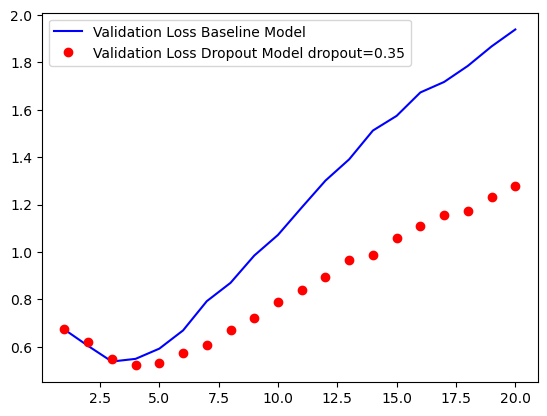

In [132]:
dropout_model = create_dropout_model(NB_WORDS, dropout_rate=0.35)
dropout_history = train_deep_model(dropout_model) 
compare_loss_with_baseline(dropout_history, 'Dropout Model dropout=0.35')

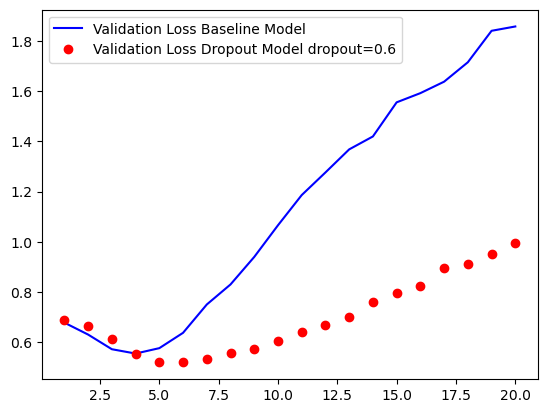

In [109]:
dropout_model = create_dropout_model(NB_WORDS, dropout_rate=0.6)
dropout_history = train_deep_model(dropout_model) 
compare_loss_with_baseline(dropout_history, 'Dropout Model dropout=0.6')

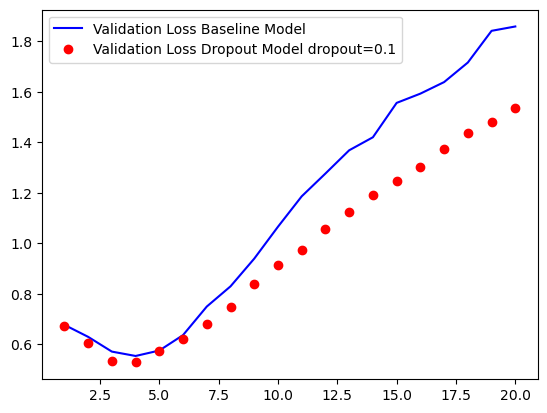

In [110]:
dropout_model = create_dropout_model(NB_WORDS, dropout_rate=0.1)
dropout_history = train_deep_model(dropout_model) 
compare_loss_with_baseline(dropout_history, 'Dropout Model dropout=0.1')

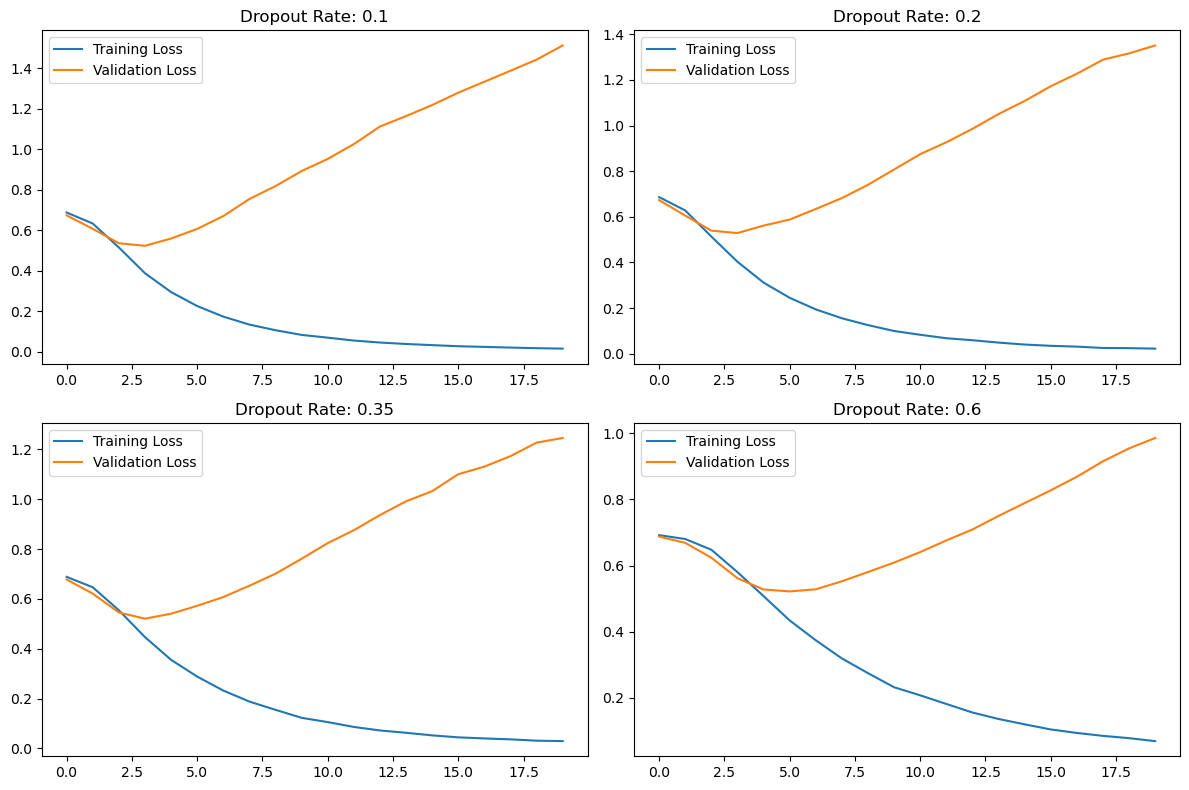

In [22]:
import matplotlib.pyplot as plt

dropout_rates = [0.1, 0.2, 0.35, 0.6]
dropout_models = []
dropout_histories = []

# create models and train them
for rate in dropout_rates:
    dropout_model = create_dropout_model(NB_WORDS, dropout_rate=rate)
    history = train_deep_model(dropout_model)
    dropout_models.append(dropout_model)
    dropout_histories.append(history)

# plot histories in subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
for i, (rate, history) in enumerate(zip(dropout_rates, dropout_histories)):
    axs[i].plot(history.history['loss'], label='Training Loss')
    axs[i].plot(history.history['val_loss'], label='Validation Loss')
    axs[i].set_title(f"Dropout Rate: {rate}")
    axs[i].legend()
plt.tight_layout()
plt.show()


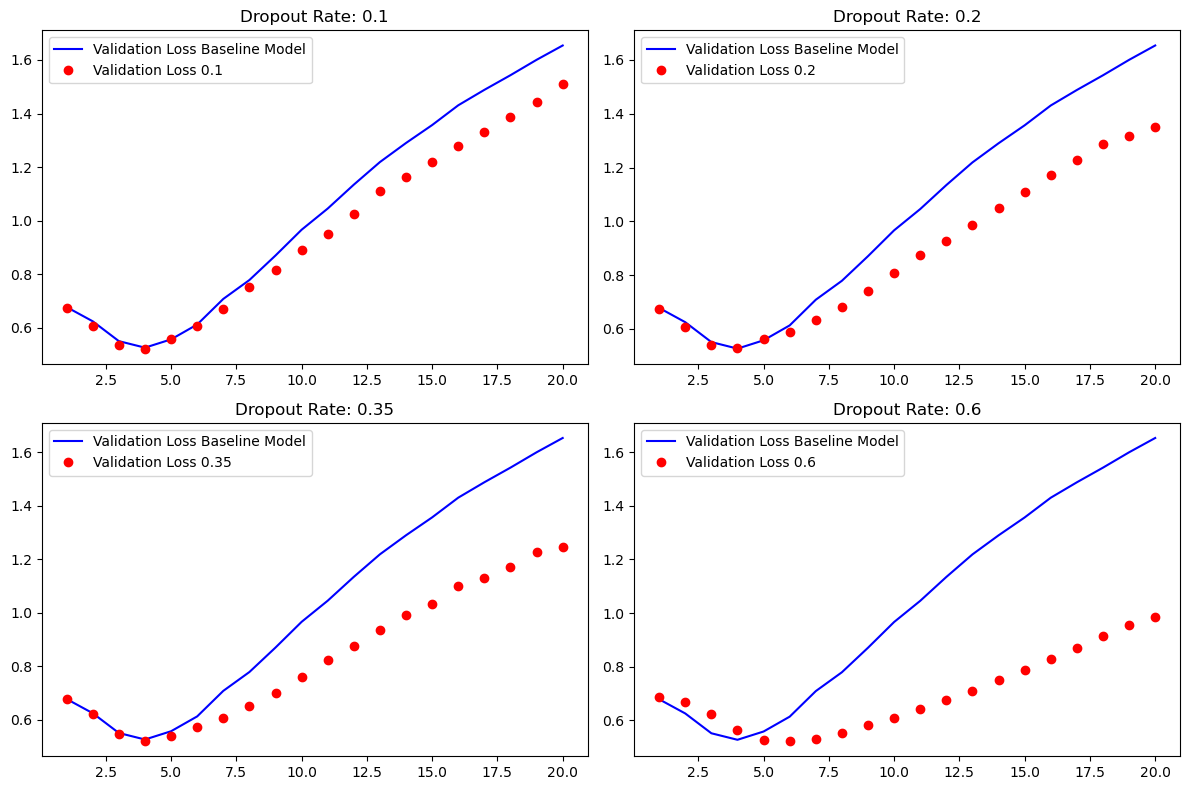

In [23]:
# plot histories in subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
for i, (rate, history) in enumerate(zip(dropout_rates, dropout_histories)):
    
        #compare_loss_with_baseline(dropout_histories[i], f'Dropout Model dropout={dropout_rates[i]}')
    baseline_val_loss = base_history.history['val_loss']
    model_loss = dropout_histories[i].history['val_loss']
    epochs = range(1, len(baseline_val_loss) + 1)
    
    axs[i].plot(epochs, baseline_val_loss, 'b', label='Validation Loss Baseline Model')
    axs[i].plot(epochs, model_loss, 'ro', label='Validation Loss ' + str(dropout_rates[i]))
    axs[i].set_title(f"Dropout Rate: {rate}")
    axs[i].legend()
plt.tight_layout()
plt.show()

In [29]:
print_classification_report(dropout_models[3], X_valid, y_valid)

29/29 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       434
           1       0.75      0.71      0.73       466

    accuracy                           0.73       900
   macro avg       0.73      0.73      0.73       900
weighted avg       0.73      0.73      0.73       900



## 2. Regularisation
add a penalty for weight size to the loss function.

In [35]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

def build_reg_model(NB_WORDS, reg_rate=0.001):
    reg_model = models.Sequential()
    reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(reg_rate), activation='relu', input_shape=(NB_WORDS,)))
    reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(reg_rate), activation='relu'))
    reg_model.add(layers.Dense(2, activation='softmax'))
    reg_model.summary()
    return reg_model


In [36]:
reg_model = build_reg_model(NB_WORDS=10000,reg_rate = 0.002)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 64)                640064    
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 2)                 130       
                                                                 
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


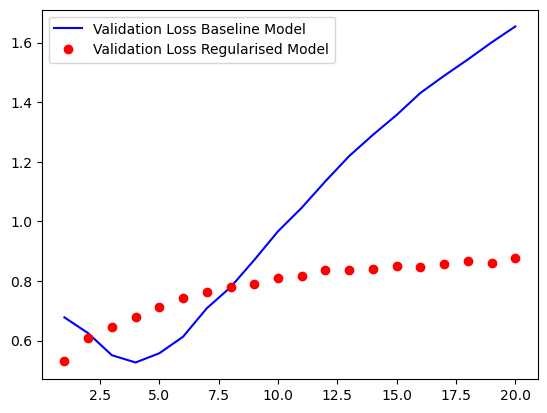

In [46]:
reg_history = train_deep_model(reg_model)
compare_loss_with_baseline(reg_history, 'Regularised Model')

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_187 (Dense)           (None, 64)                640064    
                                                                 
 dense_188 (Dense)           (None, 64)                4160      
                                                                 
 dense_189 (Dense)           (None, 2)                 130       
                                                                 
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_190 (Dense)           (None, 64)                640064    
                                                                 
 dense_191 (Dense)      

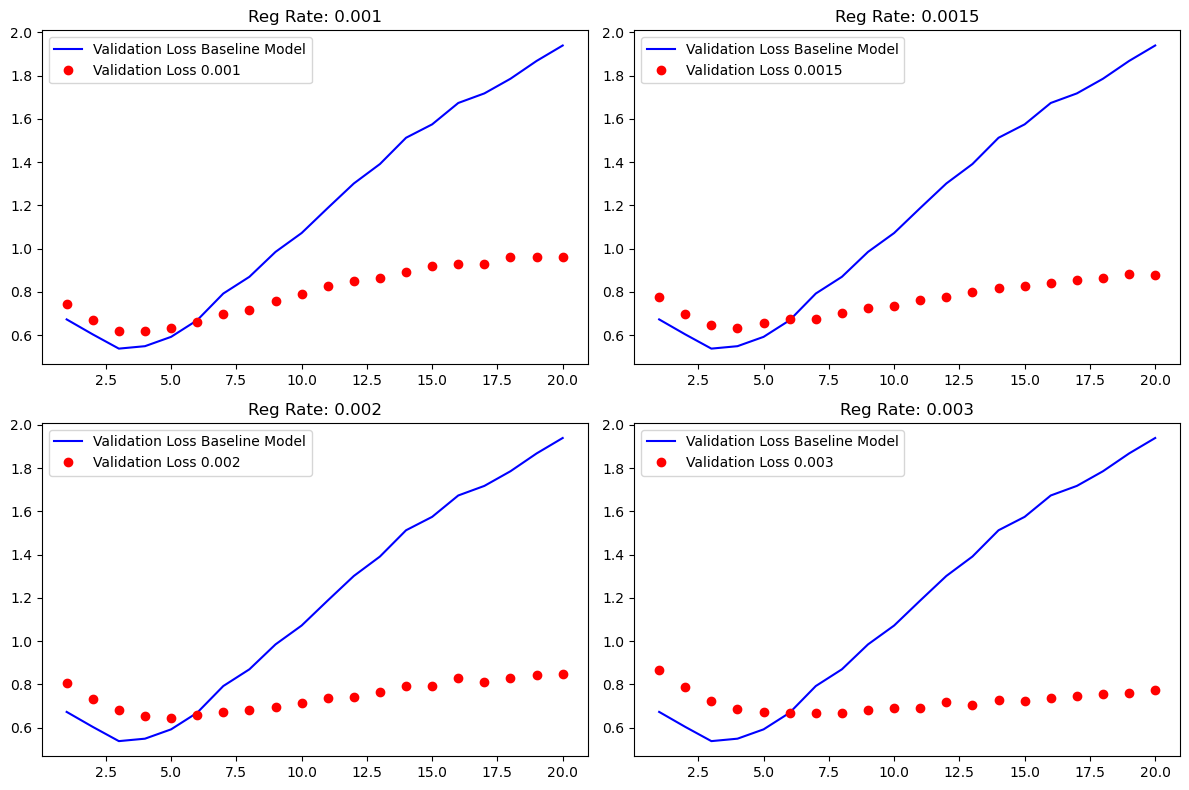

In [162]:
import matplotlib.pyplot as plt

reg_rates = [0.001, 0.0015, 0.002, 0.003]
reg_models = []
reg_histories = []

# create models and train them
for rate in reg_rates:
    reg_model = build_reg_model(NB_WORDS, reg_rate = rate)
    reg_history = train_deep_model(reg_model)
    reg_models.append(reg_model)
    reg_histories.append(reg_history)


# plot histories in subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
for i, (reg_rate, reg_history) in enumerate(zip(reg_rates, reg_histories)):
    
        #compare_loss_with_baseline(dropout_histories[i], f'Dropout Model dropout={dropout_rates[i]}')
    baseline_val_loss = base_history.history['val_loss']
    model_loss = reg_histories[i].history['val_loss']
    epochs = range(1, len(baseline_val_loss) + 1)
    
    axs[i].plot(epochs, baseline_val_loss, 'b', label='Validation Loss Baseline Model')
    axs[i].plot(epochs, model_loss, 'ro', label='Validation Loss ' + str(reg_rates[i]))
    axs[i].set_title(f"Reg Rate: {reg_rate}")
    axs[i].legend()
plt.tight_layout()
plt.show()

In [163]:
print_classification_report(reg_model, X_valid, y_valid)

29/29 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       434
           1       0.74      0.72      0.73       466

    accuracy                           0.72       900
   macro avg       0.72      0.72      0.72       900
weighted avg       0.72      0.72      0.72       900



## 3. Reducing Layers

In [39]:
def build_redlay_model(NB_WORDS):
    redlay_model = models.Sequential()
    redlay_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
    redlay_model.add(layers.Dense(2, activation='softmax'))
    redlay_model.summary()
    return redlay_model

In [40]:
redlay_model = build_redlay_model(NB_WORDS=10000)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 32)                320032    
                                                                 
 dense_30 (Dense)            (None, 2)                 66        
                                                                 
Total params: 320,098
Trainable params: 320,098
Non-trainable params: 0
_________________________________________________________________


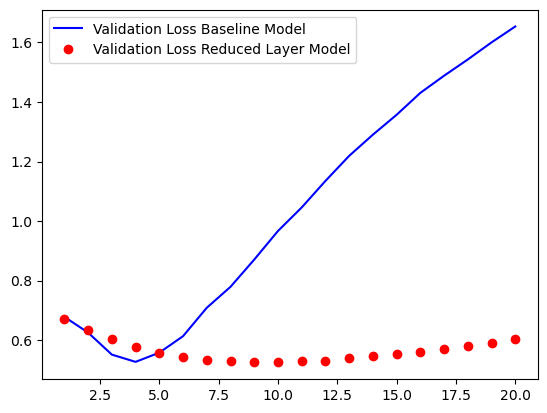

In [41]:
redlay_history = train_deep_model(redlay_model)
compare_loss_with_baseline(redlay_history, 'Reduced Layer Model')

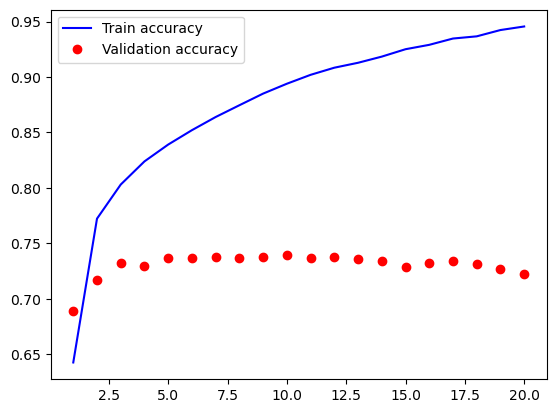

In [42]:
plot_metric(redlay_history, 'accuracy')

# EVALUATE

In [43]:
def eval_model(model, epoch_stop):
    model.fit(X_train_oh, 
              y_train_oh, 
              epochs=epoch_stop, 
              batch_size=BATCH_SIZE, 
              verbose=0)
    
    results = model.evaluate(X_test_oh, y_test_oh)
    #pred = model.predict(y_test_oh)

    return results

In [81]:
#base_results

[3.144683361053467, 0.6930000185966492]

In [44]:
import pandas as pd

# Evaluate the accuracy of four different machine learning models
base_results = eval_model(base_model, 4)
redlay_results = eval_model(redlay_model, 10)
reg_results = eval_model(reg_model, 5)
dropout_results = eval_model(dropout_model, 8)

# Store the results in a dataframe
results_df = pd.DataFrame({
    'Model': ['Baseline', 'ReducedLayer', 'Regularized', 'Dropout'],
    'Test Accuracy (%)': [base_results[1]*100, redlay_results[1]*100, reg_results[1]*100, dropout_results[1]*100]
})

# Set the index to the 'Model' column
results_df = results_df.set_index('Model')
results_df.style.highlight_max()
# Display the results as a table
print(results_df.to_string(index=True, float_format="{:.2f}".format))

32/32 [==============================] - 0s 1ms/step - loss: 0.9875 - accuracy: 0.7150
              Test Accuracy (%)
Model                          
Baseline                  71.10
ReducedLayer              72.40
Regularized               73.20
Dropout                   71.50


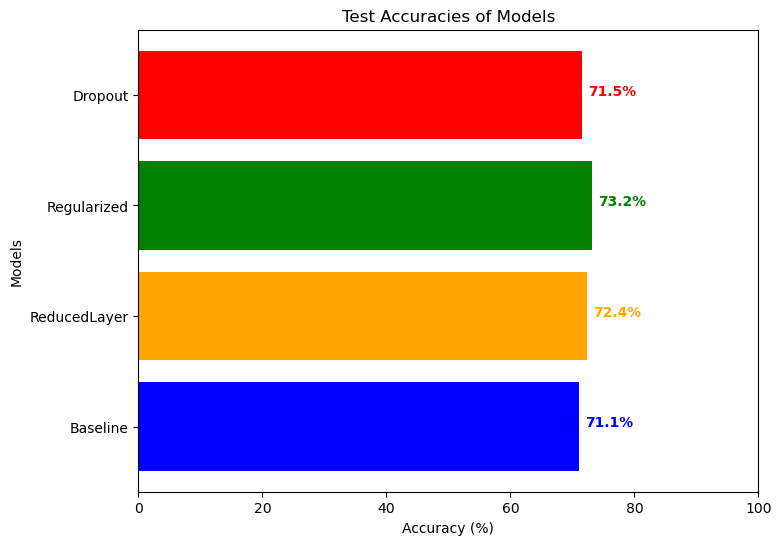

In [45]:
import matplotlib.pyplot as plt

model_names = ['Baseline', 'ReducedLayer', 'Regularized', 'Dropout']
model_accuracies = [base_results[1]*100, redlay_results[1]*100, reg_results[1]*100, dropout_results[1]*100]

fig, ax = plt.subplots(figsize=(8,6))
colors = ['blue', 'orange', 'green', 'red']
ax.barh(model_names, model_accuracies, color=colors)

# Add labels and title
ax.set_xlabel('Accuracy (%)')
ax.set_ylabel('Models')
ax.set_title('Test Accuracies of Models')

# Add values to the bars
for i, v in enumerate(model_accuracies):
    ax.text(v + 1, i, str(round(v,2))+'%', color=colors[i], fontweight='bold')

# Set the x-axis limit
plt.xlim([0, 100])

# Show the plot
plt.show()


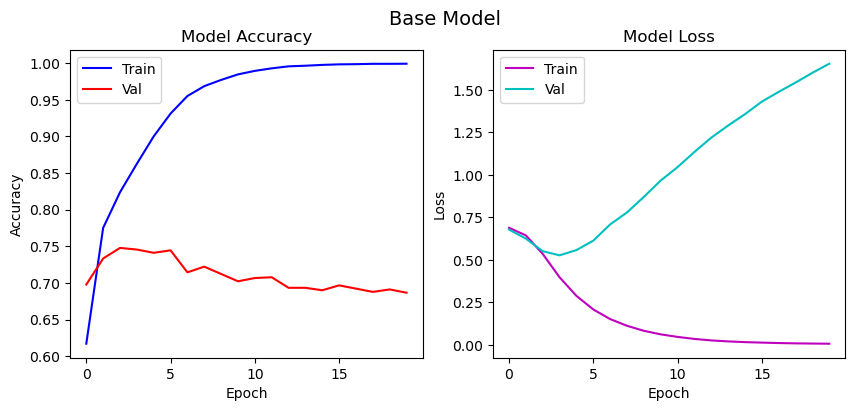

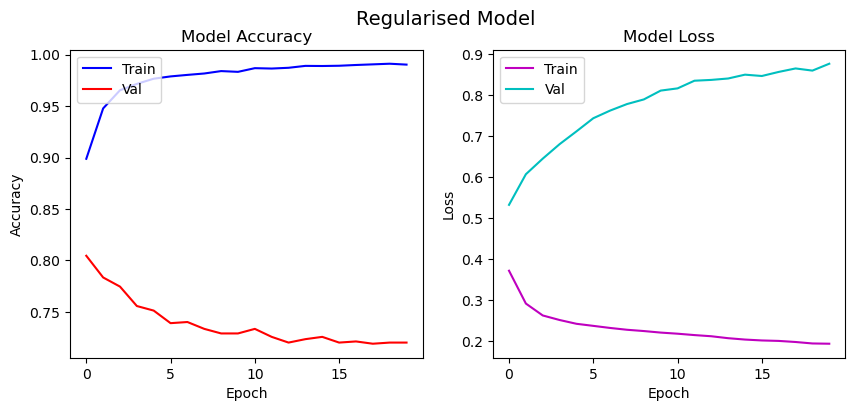

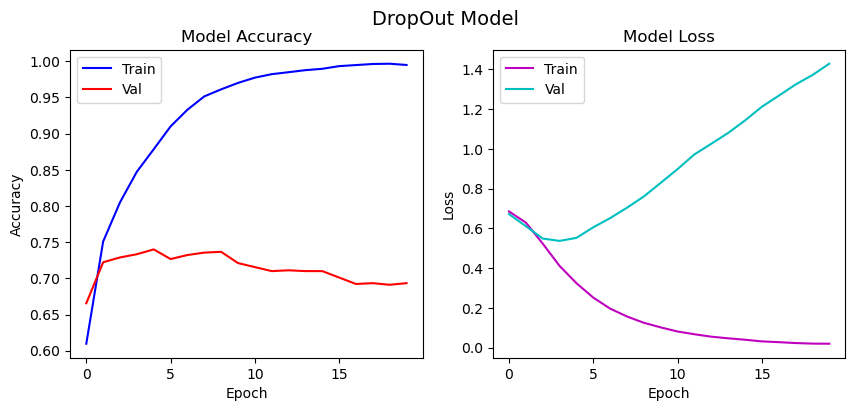

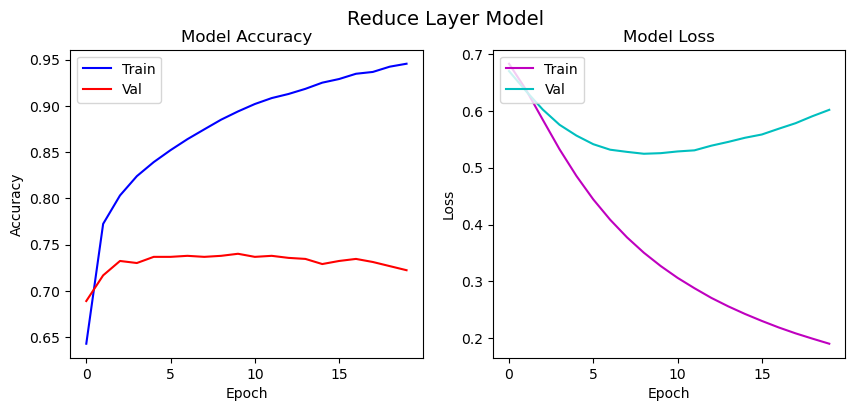

In [47]:
plot_hist(base_history,'Base Model')
plot_hist(reg_history,'Regularised Model')
plot_hist(dropout_history,'DropOut Model')
plot_hist(redlay_history,'Reduce Layer Model')

In [88]:
def compare_model_performance(history, model_name):
    # Extract validation loss for baseline and current model
    loss_baseline = base_history.history['val_loss']
    loss_current = history.history['val_loss']

    # Extract metrics for training and validation
    metric_name = 'accuracy'
    metric_train = history.history[metric_name]
    metric_val = history.history['val_' + metric_name]

    # Create subplots for comparison
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot validation loss comparison
    axs[0].plot(range(1, NB_START_EPOCHS + 1), loss_baseline, 'bo', label='Baseline')
    axs[0].plot(range(1, NB_START_EPOCHS + 1), loss_current, 'g', label=model_name)
    axs[0].set_title('Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot metric comparison
    axs[1].plot(range(1, NB_START_EPOCHS + 1), metric_train, 'bo', label='Train')
    axs[1].plot(range(1, NB_START_EPOCHS + 1), metric_val, 'r', label='Validation')
    axs[1].set_title('Metric: ' + metric_name.capitalize())
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel(metric_name.capitalize())
    axs[1].legend()

    # Show the plots
    plt.tight_layout()
    plt.show()
